<a href="https://colab.research.google.com/github/PietroDF/Sequence_to_Sequence/blob/master/Speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech recognition task

Full dataset @ http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

Inspiring tutorial @ https://dkopczyk.quantee.co.uk/speech-nn/;

Inspiring tutorial 2 @ https://www.dlology.com/blog/how-to-do-real-time-trigger-word-detection-with-keras/

# Mount Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Import

In [0]:
import os
import tarfile
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

from scipy.io import wavfile
from scipy.signal import stft

import IPython

Using TensorFlow backend.


# Dataset preparation

## Download dataset

In [0]:
!mkdir '/content/dataset_directory'

In [0]:
!wget --no-check-certificate \
    http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz \
    -O /content/dataset_directory/speech_dataset.tar.gz

--2020-03-31 09:52:02--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘/content/dataset_directory/speech_dataset.tar.gz’

/content/dataset_di 100%[===================>]   1.39G   135MB/s    in 12s     

2020-03-31 09:52:15 (115 MB/s) - ‘/content/dataset_directory/speech_dataset.tar.gz’ saved [1489096277/1489096277]



## Untar file

In [0]:
with tarfile.open('/content/dataset_directory/speech_dataset.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/dataset_directory')

In [0]:
# Image dataset
!rm /content/dataset_directory/speech_dataset.tar.gz

## Create dictionary of path and split train test

In [0]:
train_percentage = 0.6

# Local directory
local_download_path = '/content/dataset_directory/'

# Set which words need to be taken
activation_words_list = ['one']#,'house','happy']

# Negative word list
negative_words_list = ['bird','down','eight']

# Set background noise as a special word (not activation)
bg_noise = '_background_noise_'

# Create dictionary of paths
path_dict = dict()
path_dict['train'] = {}
path_dict['test'] = {}

# Fill dictionaries
for word in activation_words_list+negative_words_list+[bg_noise]:

  # Initialize list of path to sounds
  train_sounds_path = []
  test_sounds_path = []

  for filename in os.listdir(local_download_path+word):
    if filename.endswith("wav"): 

      # perform train/test split
      if np.random.rand() < train_percentage:
        train_sounds_path.append(local_download_path+word+'/'+filename)
      else:
        test_sounds_path.append(local_download_path+word+'/'+filename)

  # Add path to dictionary  
  path_dict['train'][word] = train_sounds_path
  path_dict['test'][word] = test_sounds_path

## Create dictionary of wav files

In [0]:
wav_dict = {}

for traintest in path_dict:

  for word in path_dict[traintest]:

    for wav_filename in path_dict[traintest][word]:

      # Build a unique filename
      wav_dictkey = word + '_' + (wav_filename).split('/')[-1][:-4]

      # Add to dictionary
      try:

        # Read wav file
        wav_read = wavfile.read(wav_filename)

        # Normalize the array and add to the dictionary
        wav_dict[wav_dictkey] = np.array(wav_read[1],dtype='float32') / np.iinfo(np.int16).max

      except:
        print('skipping word:'+wav_dictkey)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  app.launch_new_instance()


In [0]:
wav_dict['bird_00b01445_nohash_0']

array([-0.00750755,  0.04654073,  0.02041688, ..., -0.01004059,
       -0.01300089, -0.00250252], dtype=float32)

## Create random audio files with bg noise, positive and negative word

In [0]:
def create_input_and_label(train_or_test,num_samples=1000, word_vol = 3, audio_duration=3):

  x_input = []
  y_sequence = []
  y_label = []

  for i in range(num_samples):

    # BACKGROUND NOISE

    # Initialize bg vector
    bg_wav = np.zeros(1)

    # Build background noise choosing randomly chunk of bg noises
    while len(bg_wav)<16000*audio_duration:

      # choose a random back-ground sound
      bg_train_test = random.choice(['train','test'])
      bg_sound = random.choice(path_dict[bg_train_test][bg_noise])

      # modify the key to find it on the dictionary
      bg_sound = bg_sound.rsplit('/',2)[1]+'_'+bg_sound.rsplit('/',2)[2].split('.')[0]

      # get arrau from dictionary
      bg_sound = wav_dict[bg_sound]

      # sample a part of it
      sample_start,sample_end = (np.sort(np.random.rand(2))*len(bg_sound)*0.2).astype('int')
      bg_sound = bg_sound[sample_start:sample_end]

      # get the np array on the dictionary created
      bg_wav = np.concatenate((bg_wav,bg_sound))

    # cut audio clip to fixed length
    bg_wav = bg_wav[:16000*audio_duration]

    # create label vector
    label = np.zeros(len(bg_wav))


    # ACTIVATION WORDS

    # Add activation word proportionally to 'activation_samples_ratio'
    if np.random.rand() < activation_samples_ratio:

      index_words = (np.sort(np.random.rand(num_activation_words))*len(bg_wav)*(1-20000/len(bg_wav))).astype('int')

      for idx in index_words:

        # choose a random activation word
        activation_word = random.choice(activation_words_list)
        act_sound = random.choice(path_dict[train_or_test][activation_word])

        # modify the key to find it on the dictionary
        act_sound = act_sound.rsplit('/',2)[1]+'_'+act_sound.rsplit('/',2)[2].split('.')[0]

        # get the np array on the dictionary created
        act_wav = wav_dict[act_sound]*word_vol

        # Overlay to background
        bg_wav[idx:idx+len(act_wav)] += act_wav

        # Modify label accordingly
        label[idx:idx+len(act_wav)] = 1


    # NEGATIVE WORDS

    index_words = (np.sort(np.random.rand(num_negative_words))*len(bg_wav)*(1-20000/len(bg_wav))).astype('int')

    for idx in index_words:

      # - choose a random negative word
      negative_word = random.choice(negative_words_list)
      neg_sound = random.choice(path_dict[train_or_test][negative_word])

      # - modify the key to find it on the dictionary
      neg_sound = neg_sound.rsplit('/',2)[1]+'_'+neg_sound.rsplit('/',2)[2].split('.')[0]

      # - get the np array on the dictionary created
      neg_wav = wav_dict[neg_sound]*word_vol

      # - Overlay to background
      bg_wav[idx:idx+len(neg_wav)] += neg_wav



    # ADD THE WAV FILE TO INPUT SET

    # Normalize audio
    bg_wav = bg_wav/np.max(np.abs(bg_wav))

    x_input.append(bg_wav)
    y_sequence.append(label)

    # Una semplice label di tipo True/False
    y_label.append((np.sum(label)>0)*1)


  # - Return created value
  x_input = np.asarray(x_input)
  y_sequence = np.asarray(y_sequence)
  y_label = np.asarray(y_label)

  return x_input, y_sequence, y_label

In [0]:
# Define parameters

audio_seconds = 15

num_activation_words = 2
num_negative_words = 3 #int(audio_seconds/3+1.5)

# num samples containing activation word / num total samples
activation_samples_ratio = 0.5

# higher volume for words (positive and negative)
word_volume = 3

train_num_samples = 1500
test_num_samples = 500

In [0]:
# Create audio samples from function
x_train, y_train_sequence, y_train_label = create_input_and_label('train', train_num_samples, word_volume, audio_seconds)
x_test, y_test_sequence, y_test_label = create_input_and_label('test', test_num_samples, word_volume, audio_seconds)

In [0]:
# Expand dimensions for convolution
x_train = np.expand_dims(x_train,2)
x_test = np.expand_dims(x_test,2)

## Test on some random sounds

In [0]:
y_train_label[:5]

array([1, 1, 1, 1, 0])

In [0]:
# Function to play audio directly from Jupyter
def play_audio(x, audio_rate=16000):
  return IPython.display.Audio(x[:,0], rate=audio_rate)

In [0]:
sound_idx = 2

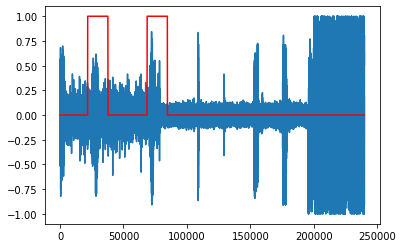

In [0]:
# Plot sound frequencies
plt.plot(x_train[sound_idx])
plt.plot(y_train_sequence[sound_idx],'-r')
plt.show()

In [0]:
play_audio(x_train[sound_idx])

# Model

In [0]:
from tensorflow.keras import layers, models, losses, callbacks

In [0]:
# Create net

net = models.Sequential()

net.add(layers.Conv1D(40,100,strides=10,padding='same', activation='relu', input_shape=(x_train[0].shape[0],1)))

net.add(layers.MaxPool1D(pool_size=5,strides=5,padding='same'))

net.add(layers.BatchNormalization())

net.add(layers.Conv1D(80,10,strides=5,padding='same', activation='relu'))

net.add(layers.MaxPool1D(pool_size=5,strides=5,padding='same'))

net.add(layers.BatchNormalization())

net.add(layers.LSTM(20, return_sequences=True))

net.add(layers.BatchNormalization())

net.add(layers.TimeDistributed(layers.Dense(1, activation = "sigmoid")))


# Compile net
net.compile(optimizer='adam',
            loss=losses.binary_crossentropy,
            metrics=['accuracy'])

# Explain net
net.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 24000, 40)         4040      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 4800, 40)          0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 4800, 40)          160       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 960, 80)           32080     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 192, 80)           0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 192, 80)           320       
_________________________________________________________________
lstm_16 (LSTM)               (None, 192, 20)         

In [0]:
def compressed_output_sequence(y_sequence, out_dimension):
  # - Post process output for labels:
  # voglio comprimere output della sequenza compressa in modo che sia del tipo:
  # [0-0-0-0-0-1-1-1-0-0-0-0-0-0-1-1-1-1-1-0-0-0]; dove:
  # 0 significa: no activation (background o negative words)
  # 1 significa: activation triggered
  # Per fare ciò prendo l'array, lo seziono in n parti tramite reshape e di ciascuna calcolo il valor medio

  # Inizializzo i vettori
  compressed_seq = np.zeros((y_sequence.shape[0],out_dimension))

  # Eseguo compressione
  for idx,seq in enumerate(y_sequence):
    compressed_seq[idx,:] = np.mean(np.reshape(seq,(out_dimension,-1)), axis=1)

  # Reshape per compatibilità con modello
  compressed_seq = np.expand_dims(compressed_seq,2)

  return compressed_seq

In [0]:
# Get model output dimension
out_dimension = net.output.shape[1]

# Compress sequences to fit the model
y_compressed_train_sequence = compressed_output_sequence(y_train_sequence,out_dimension)
y_compressed_test_sequence = compressed_output_sequence(y_test_sequence,out_dimension)

In [0]:
# Train
batch_size_value = 32
max_epochs_value = 250

early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=7, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

reduceLr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

history = net.fit(x_train, y_compressed_train_sequence,
                  batch_size = batch_size_value,
                  epochs = max_epochs_value,
                  validation_data = (x_test, y_compressed_test_sequence),
                  shuffle = True,
                  callbacks=[early_stopping, reduceLr],
                  verbose=1
                  )

Epoch 1/250
47/47 [==============================] - 37s 780ms/step - loss: 0.5083 - accuracy: 0.9043 - val_loss: 0.5100 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 2/250
47/47 [==============================] - 35s 754ms/step - loss: 0.3993 - accuracy: 0.9271 - val_loss: 0.4865 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 3/250
47/47 [==============================] - 36s 760ms/step - loss: 0.3080 - accuracy: 0.9376 - val_loss: 0.3759 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 4/250
47/47 [==============================] - 35s 753ms/step - loss: 0.2406 - accuracy: 0.9441 - val_loss: 0.3671 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 5/250
47/47 [==============================] - 36s 755ms/step - loss: 0.1986 - accuracy: 0.9480 - val_loss: 0.3480 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 6/250
47/47 [==============================] - 36s 764ms/step - loss: 0.1724 - accuracy: 0.9507 - val_loss: 0.3653 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 7/250
47/47 [==============================] - 36s 7

## Metriche

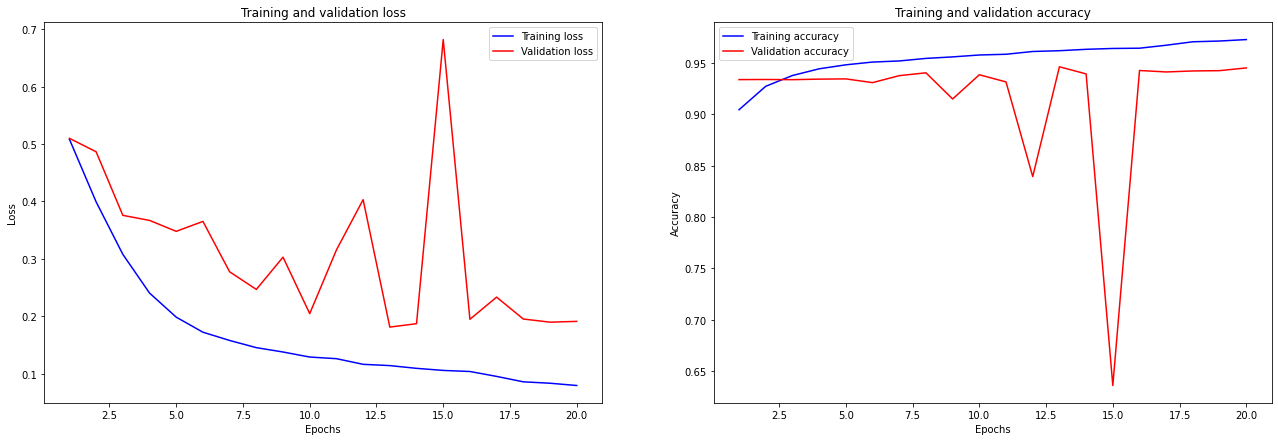

In [0]:
# Plot Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(22,7))

plt.subplot(1,2,1)
plt.plot(epochs, loss, '-b', label='Training loss')
plt.plot(epochs, val_loss, '-r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, acc, '-b', label='Training accuracy')
plt.plot(epochs, val_acc, '-r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save and Load old model

In [0]:
net_parameters = 'cnn_lstm'

### Save model

In [0]:
net.save('/gdrive/My Drive/ML & AI/Colab/Model_weights/speech_recognition_'+net_parameters+'.h5')

### Load old model

In [0]:
from keras.models import load_model

In [0]:
net = load_model('/gdrive/My Drive/ML & AI/Colab/Model_weights/speech_recognition_'+net_parameters+'.h5')

# Simulate prediction on test set

In [0]:
prediction = net.predict(x_test)

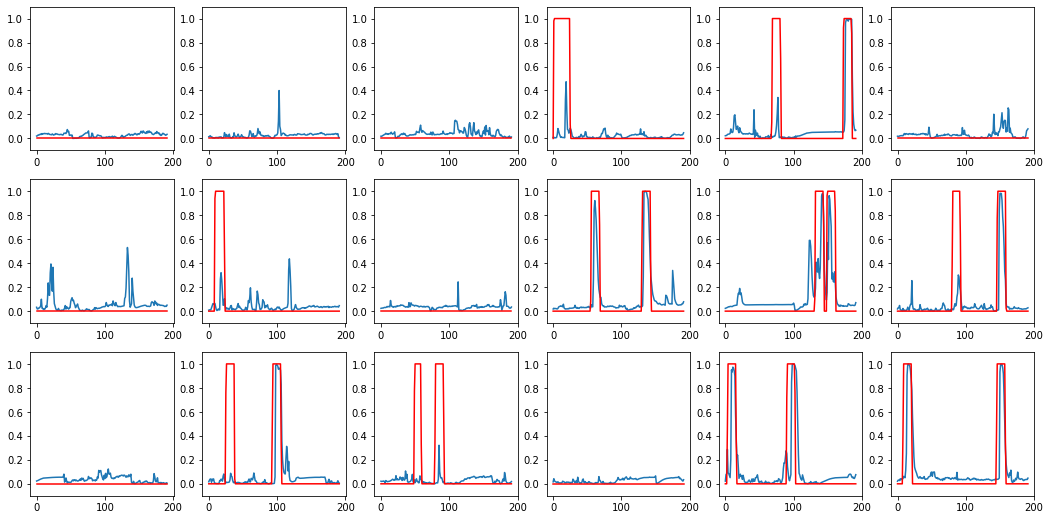

In [0]:
num_rows = 3
num_cols = 6

plt.figure(figsize=(3*num_cols,3*num_rows))

for graph_idx in range(num_rows*num_cols):

  idx = np.random.randint(0,y_compressed_test_sequence.shape[0])
  plt.subplot(num_rows,num_cols,graph_idx+1)
  plt.plot(prediction[idx],label='predicted')
  plt.plot(y_compressed_test_sequence[idx],'-r',label='real')
  plt.ylim([-0.1,1.1])
  #plt.legend()

plt.show()

# Record audio and perform prediction

In [0]:
net.evaluate(x_test, y_compressed_test_sequence)

16/16 [==============================] - 2s 147ms/step - loss: 0.1813 - accuracy: 0.9461


[0.18128784000873566, 0.9460729360580444]

In [0]:
play_audio(x_test[10])

In [0]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pyaudio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.2).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 1s (266 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 133872 files and directories currently installed.)
Prepari

In [0]:
import pyaudio
import wave

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 3
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

Recording


OSError: ignored